### Assignment 3: Graph Visualization

#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg) 

This assignment looks at a CSV of Donor + Donor Recipient Data from OpenSecret, which tracks political donations.

This particular dataset tracks the donation total during the 2020 election cycle from individuals, companies, and PACs/Super PACs to the 148 members of congress who objected to certification of 2020 Electoral College results in January 2021.

This data is available [here](https://docs.google.com/spreadsheets/d/1PPjz-U1LueQYHaVCU8iCYf3O4lc-OYN7uOf3OknhYxo/edit#gid=1325242852). 


In [68]:
import networkx as nx
import pandas
import matplotlib.pyplot as plt

First we import the CSV and do a couple quick checks to see the shape and form of the data. 

In [20]:
df = pandas.read_csv('donor_members.csv')
df.head()

PAC        CID           CRPName Distid    Total  \
0  American Medical Assn  N00025219  Burgess, Michael   TX26  $20,000   
1  American Medical Assn  N00028152   McCarthy, Kevin   CA23  $20,000   
2   American Dental Assn  N00005736      Babin, Brian   TX36  $20,000   
3   American Dental Assn  N00025219  Burgess, Michael   TX26  $20,000   
4   American Dental Assn  N00035346     Carter, Buddy   GA01  $17,500   

   Unnamed: 5                                         Unnamed: 6  
0         NaN                                                NaN  
1         NaN  Direct contributions data covers the 2020 elec...  
2         NaN                                                NaN  
3         NaN                                                NaN  
4         NaN                                                NaN

In [21]:
df.shape

(2686, 7)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PAC         2686 non-null   object 
 1   CID         2686 non-null   object 
 2   CRPName     2686 non-null   object 
 3   Distid      2686 non-null   object 
 4   Total       2686 non-null   int64  
 5   Unnamed: 5  0 non-null      float64
 6   Unnamed: 6  1 non-null      object 
dtypes: float64(1), int64(1), object(5)
memory usage: 147.0+ KB


Convert the `Total` (donation) column to integer

In [57]:
df.Total = [int(''.join(c for c in donation if str.isnumeric(c))) for donation in df.Total]

In [60]:
print(f'Donations range from {min(df.Total)} to {max(df.Total)} dollars.')

Donations range from 10000 to 30000 dollars.


Then, we use the `from_pandas_dataframe` function to create a networkx graph from the dataframe. [Source](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.from_pandas_dataframe.html). 

In [61]:
test_graph = nx.from_pandas_dataframe(df, source="PAC", target="CRPName",
                                  edge_attr=["Total"])

In [62]:
print(nx.info(test_graph))

Name: 
Type: Graph
Number of nodes: 712
Number of edges: 2675
Average degree:   7.5140


For this assignment we want to explore diameter. However, diameter requires a connected graph. First, let's check if this graph is, with the `is_connected` function. [Source](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.is_connected.html#networkx.algorithms.components.is_connected).

In [24]:
print(nx.is_connected(test_graph))

False


This graph is not connected. We can look for subgraphs that are however, and focus measurement there. The `connected_component_subgraphs` function generates any available connected subgraphs. [Source](https://networkx.org/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.components.connected.connected_component_subgraphs.html).

In [64]:
graphs = list(nx.connected_component_subgraphs(test_graph))
print("There are", len(graphs), "connected subgraphs in this graph.")

There are 2 connected subgraphs in this graph.


Let's compare the size of these subgraphs by the number of nodes.

In [65]:
print("The first subgraph has", len(graphs[0].nodes()), "nodes.")
print("The second subgraph has", len(graphs[1].nodes()), "nodes.")

The first subgraph has 710 nodes.
The second subgraph has 2 nodes.


Let's select the larger of the two, and explore further.



In [27]:
subgraph_test = graphs[0]

colors = []
for node in subgraph_test:
    if node in df["CRPName"].values:
        colors.append("violet")
    else: colors.append("lightgreen")
        
#node colors `for` loop source: https://stackoverflow.com/a/59473049

/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


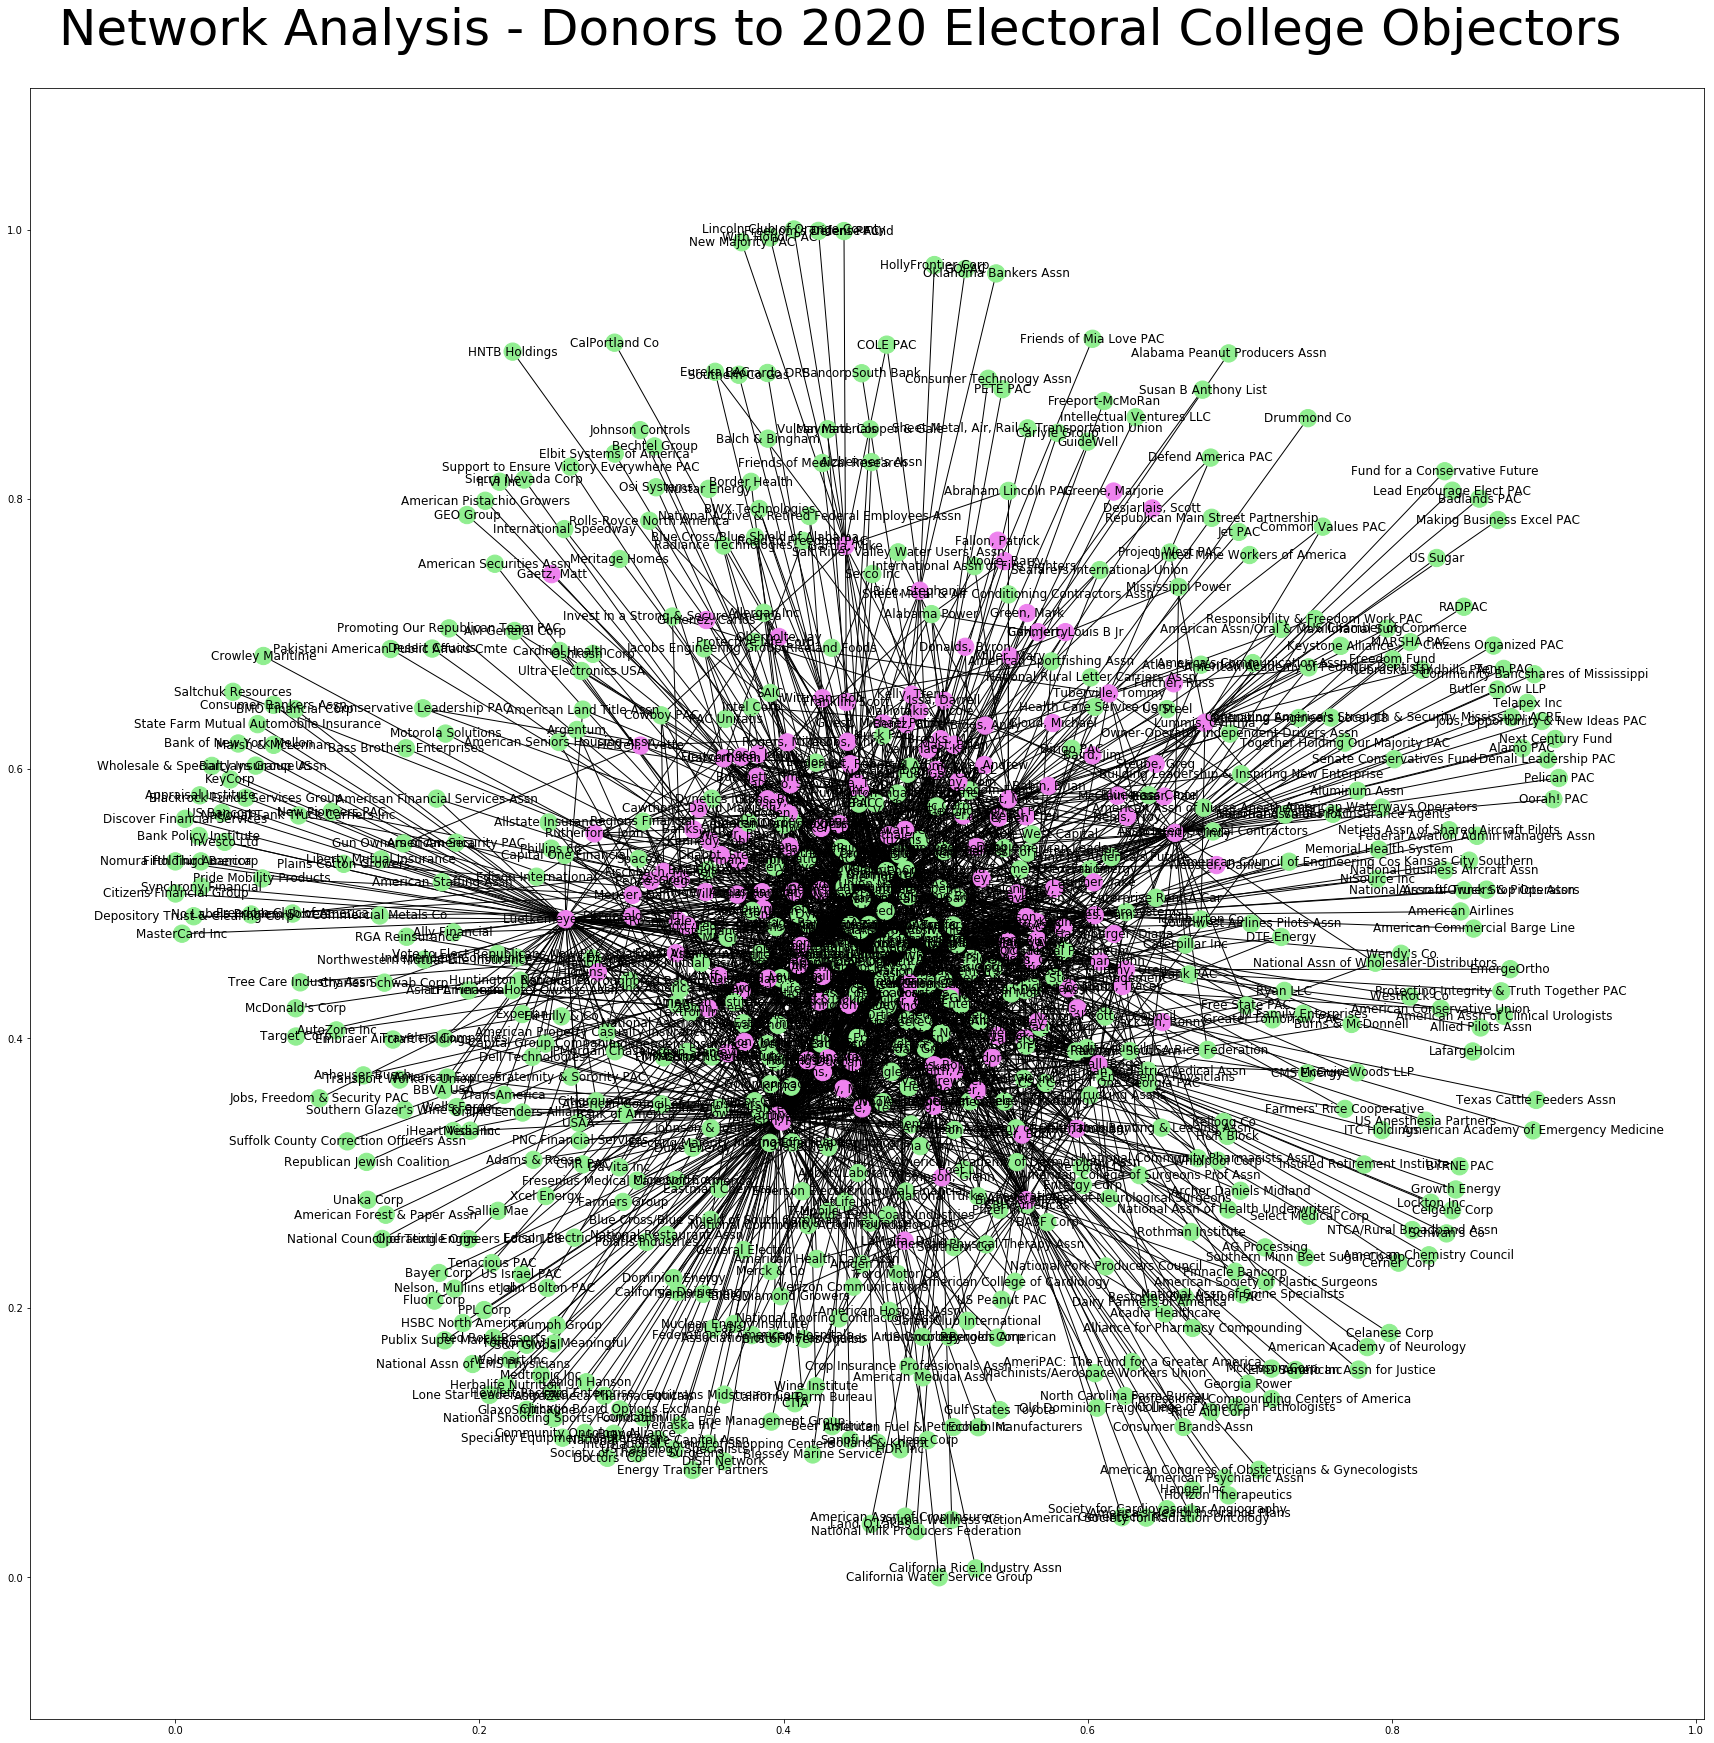

In [28]:
plt.figure(figsize = (30, 30))
ax = plt.subplot()

nx.draw_networkx(subgraph_test, ax=ax, node_color=colors)

plt.figtext(.5,.9,'Network Analysis - Donors to 2020 Electoral College Objectors', fontsize=50, ha='center')
plt.show()

We can use the built in diameter function to determine the diameter of this subgraph.

In [70]:
diameter_test = nx.diameter(subgraph_test)

In [71]:
print("The diameter is: ", diameter_test)

The diameter is:  6


We can also look at top nodes based on some of our centrality measures, e.g. degree centrality, closeness, and betweenness. We start by pulling the sorted_map function from [the textbook's repo](https://www.oreilly.com/library/view/social-network-analysis/9781449311377/), then using different NetworkX built in centrality functions. 

In [31]:
def sorted_map(dd: dict) -> dict:
    """
    Sorts dict by its values (desc)
    
    :param dd: dictionary with numeric values
    :return sorted dictionary ordered by its numeric value
    """
    sorted_dict = sorted(dd.items(), key=lambda x: (-x[1], x[0]))
    return sorted_dict

In [32]:
d = nx.degree_centrality(subgraph_test)
ds = sorted_map(d)
ds[:10]

[('McCarthy, Kevin', 0.22284908321579688),
 ('Majority Cmte PAC', 0.1706629055007052),
 ('Scalise, Steve', 0.1466854724964739),
 ('Luetkemeyer, Blaine', 0.12552891396332863),
 ('Hudson, Richard', 0.10155148095909731),
 ('American Bankers Assn', 0.09449929478138222),
 ('Stefanik, Elise', 0.09449929478138222),
 ('Marshall, Roger', 0.09026798307475317),
 ('Graves, Sam', 0.08603667136812412),
 ('National Auto Dealers Assn', 0.0846262341325811)]

In [33]:
c = nx.closeness_centrality(subgraph_test)
cs = sorted_map(c)
cs[:10]

[('Majority Cmte PAC', 0.47583892617449663),
 ('American Bankers Assn', 0.4425717852684145),
 ('National Auto Dealers Assn', 0.43443627450980393),
 ('McCarthy, Kevin', 0.4180424528301887),
 ('American Crystal Sugar', 0.4141355140186916),
 ('National Assn of Realtors', 0.4122093023255814),
 ('Comcast Corp', 0.4065366972477064),
 ('AT&T Inc', 0.40101809954751133),
 ('Koch Industries', 0.3978675645342312),
 ('Scalise, Steve', 0.39214601769911506)]

In [34]:
b = nx.betweenness_centrality(subgraph_test)
bs = sorted_map(b)
bs[:10]

[('Majority Cmte PAC', 0.1728287711734531),
 ('McCarthy, Kevin', 0.16931791360004353),
 ('Luetkemeyer, Blaine', 0.0926089052674051),
 ('Scalise, Steve', 0.07678017910891105),
 ('Hyde-Smith, Cindy', 0.06477478319404825),
 ('American Bankers Assn', 0.059420459128165966),
 ('Hudson, Richard', 0.053983861783237955),
 ('Marshall, Roger', 0.05367059974479934),
 ('National Auto Dealers Assn', 0.05243269238376079),
 ('Graves, Sam', 0.051492943847402786)]

There are some consistent names across all 3.

#### Let's look at the more central nodes in the graph

In [119]:
# while we're at it, let's make it bipartite 
from networkx.algorithms import bipartite

# separates pols from PACs
pols = set(df.CRPName)
pacs = set(df.PAC)

bip = nx.Graph()
bip.add_nodes_from(pols, bipartite=0)
bip.add_nodes_from(pacs, bipartite=1)

bip.add_weighted_edges_from(zip(df.CRPName, df.PAC, df.Total), weight='donation')

#### If we only consider nodes with more connections, what's a good cutoff to remove the others?

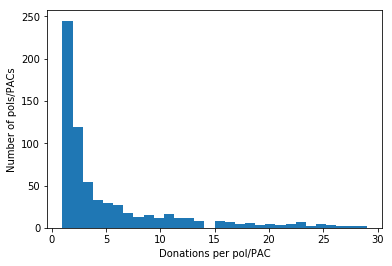

In [120]:
plt.hist([len(bip[n]) for n in bip if len(bip[n]) < 30], bins=30)
plt.xlabel('Donations per pol/PAC')
plt.ylabel('Number of pols/PACs');

Looks like removing nodes with 3 or fewer connections will remove over half of them

In [122]:
# Resulting graph still too crowded.  How about 10 or more connections:
bigs = [n for n in bip if len(bip[n]) > 10]
bigs = bip.subgraph(bigs)        
len(bigs.nodes())

148

In [131]:
colors = ['lightgreen' if n in pacs else 'violet' for n in bigs]
len(colors)

148

/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


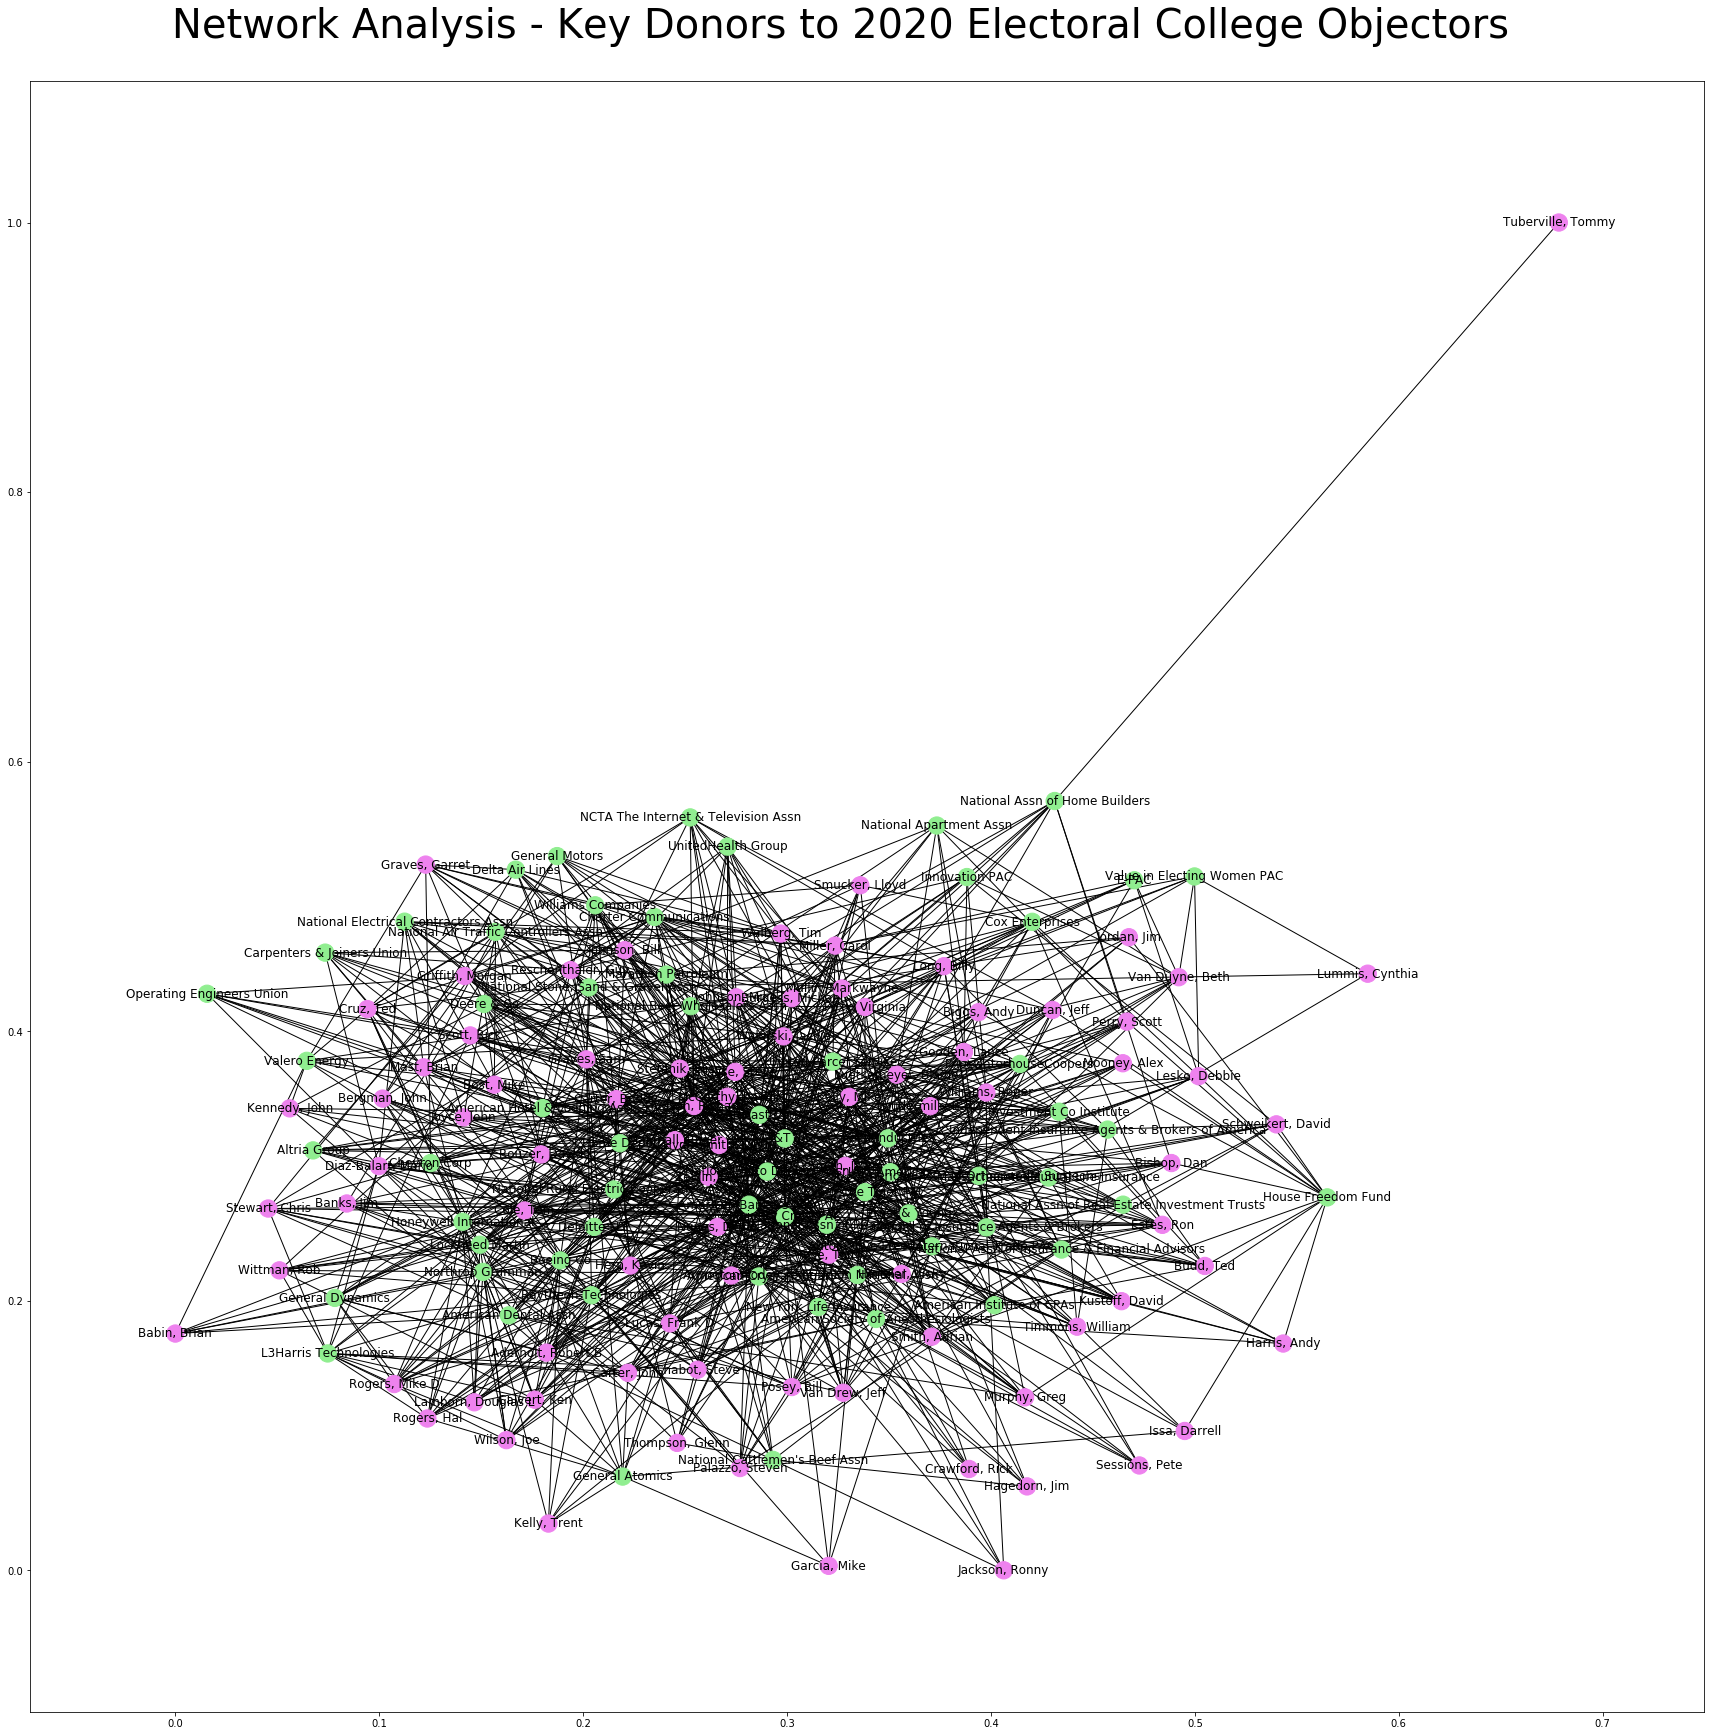

In [132]:
plt.figure(figsize = (30, 30))
ax = plt.subplot()

nx.draw_networkx(bigs, ax=ax, node_color=colors)

plt.figtext(.5,.9,'Network Analysis - Key Donors to 2020 Electoral College Objectors', fontsize=40, ha='center')
plt.show()

### Look at only the pols and PACs who appear in the top 20 of at least one centrality measure

In [147]:
centrals = [n for n in bip if (n in list(zip(*ds[:20]))[0]
                               or n in list(zip(*bs[:20]))[0]
                               or n in list(zip(*cs[:20]))[0])]
centrals = bip.subgraph(centrals)
len(centrals)                              

25

In [148]:
colors = ['lightgreen' if n in pacs else 'violet' for n in centrals]
len(colors)

25

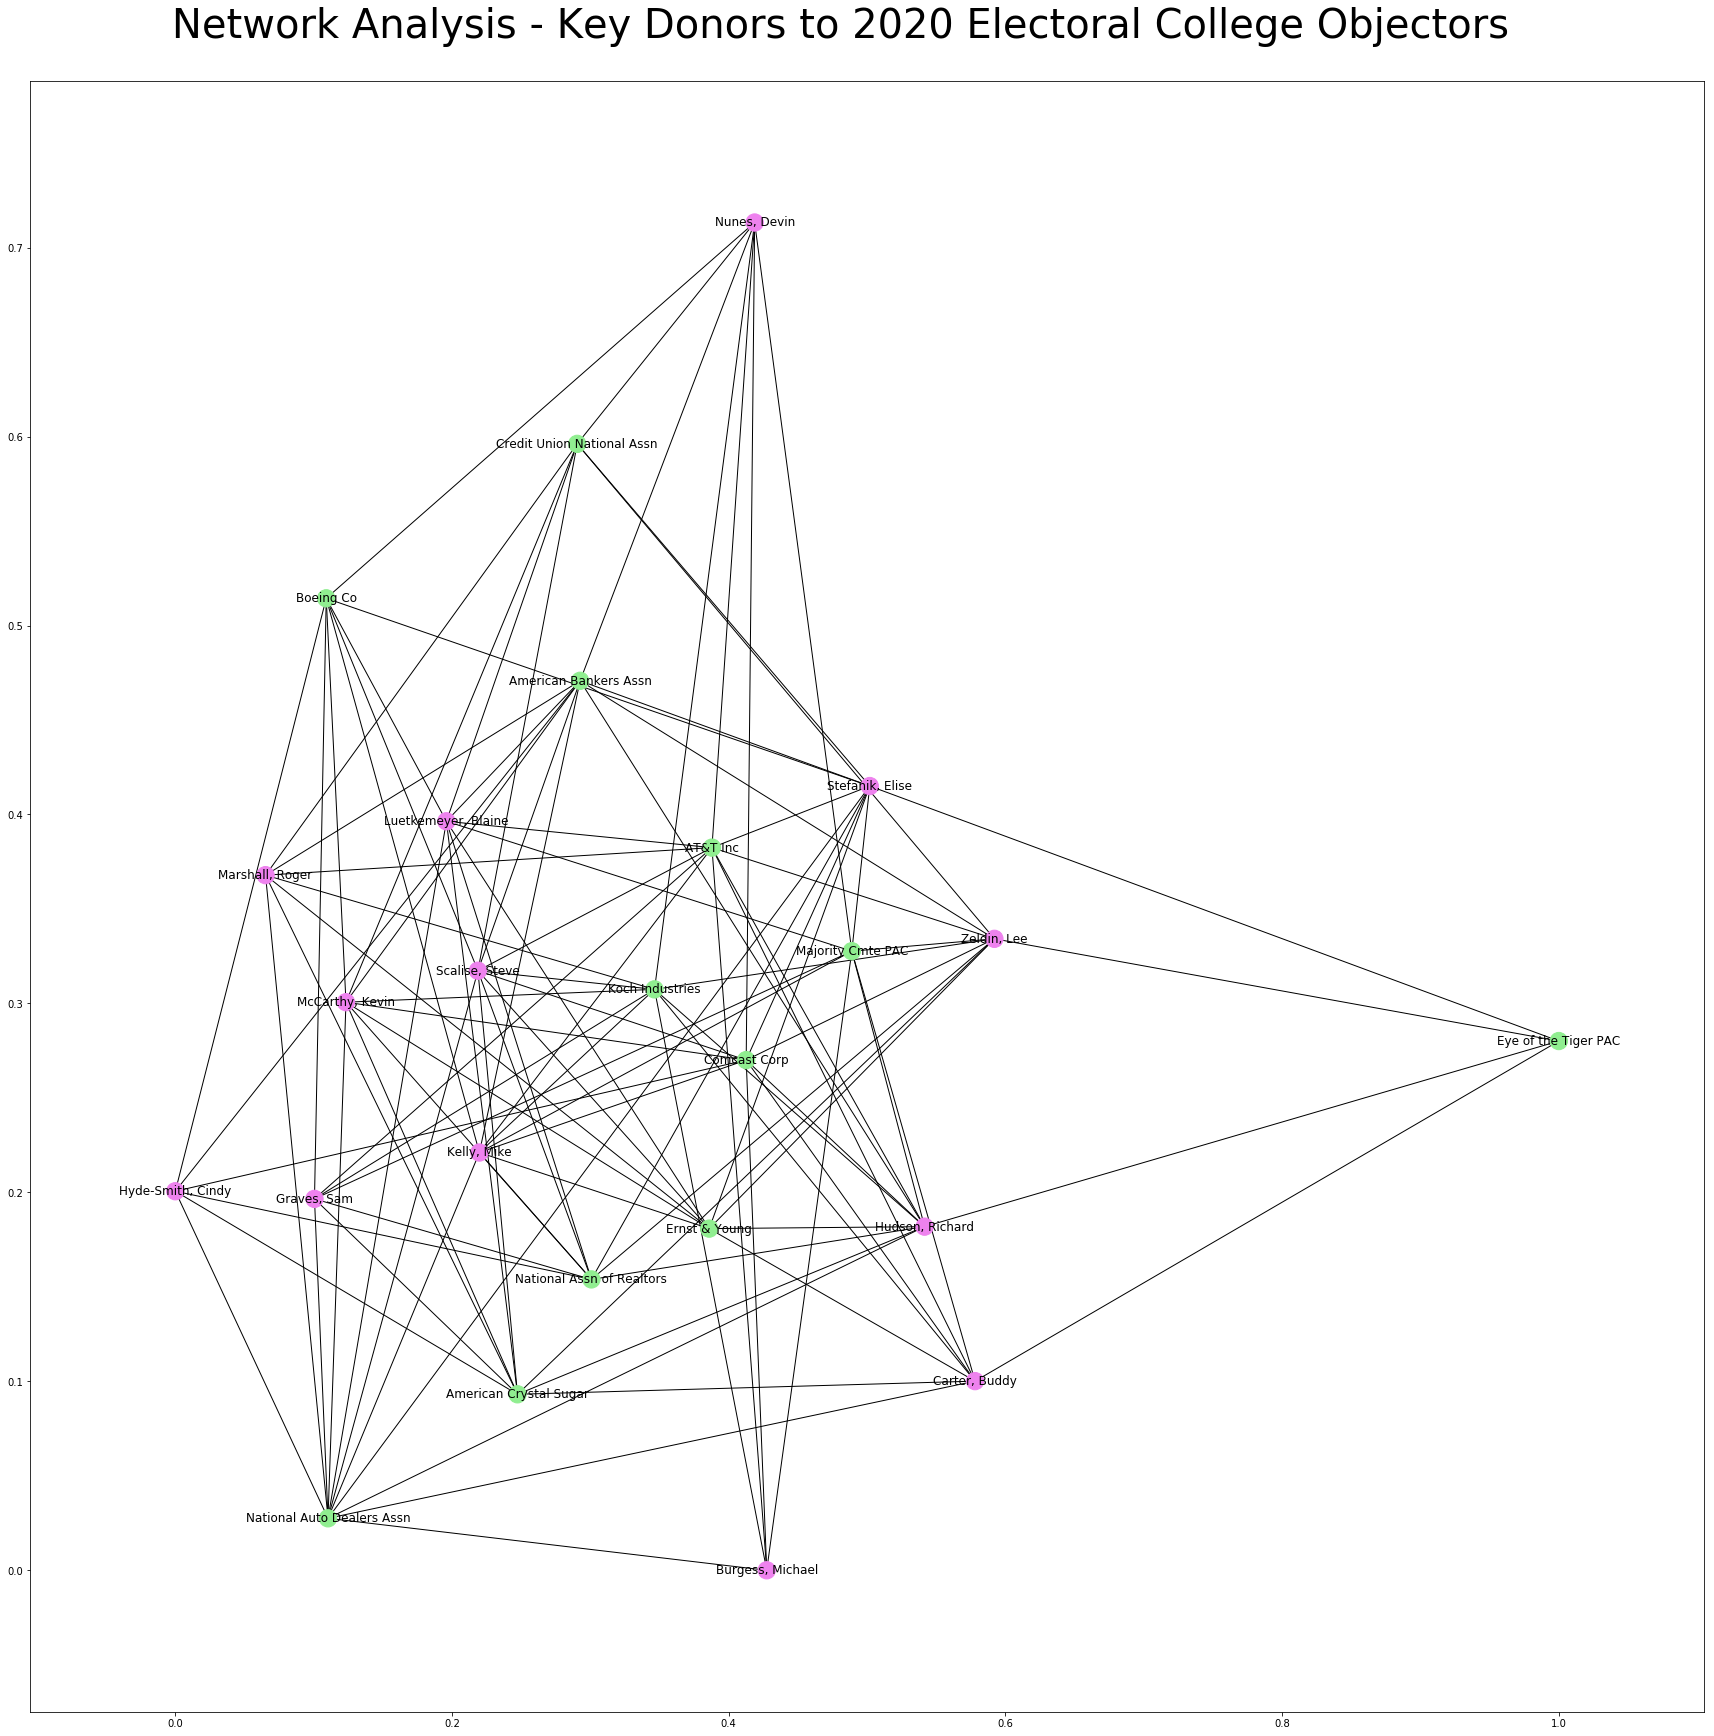

In [149]:
plt.figure(figsize = (30, 30))
ax = plt.subplot()

nx.draw_networkx(centrals, ax=ax, node_color=colors)

plt.figtext(.5,.9,'Network Analysis - Key Donors and 2020 Electoral College Objectors', fontsize=40, ha='center')
plt.show()

Project the bipartite graph onto the politician side

In [153]:
lpart = bipartite.weighted_projected_graph(bip, pols)

/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


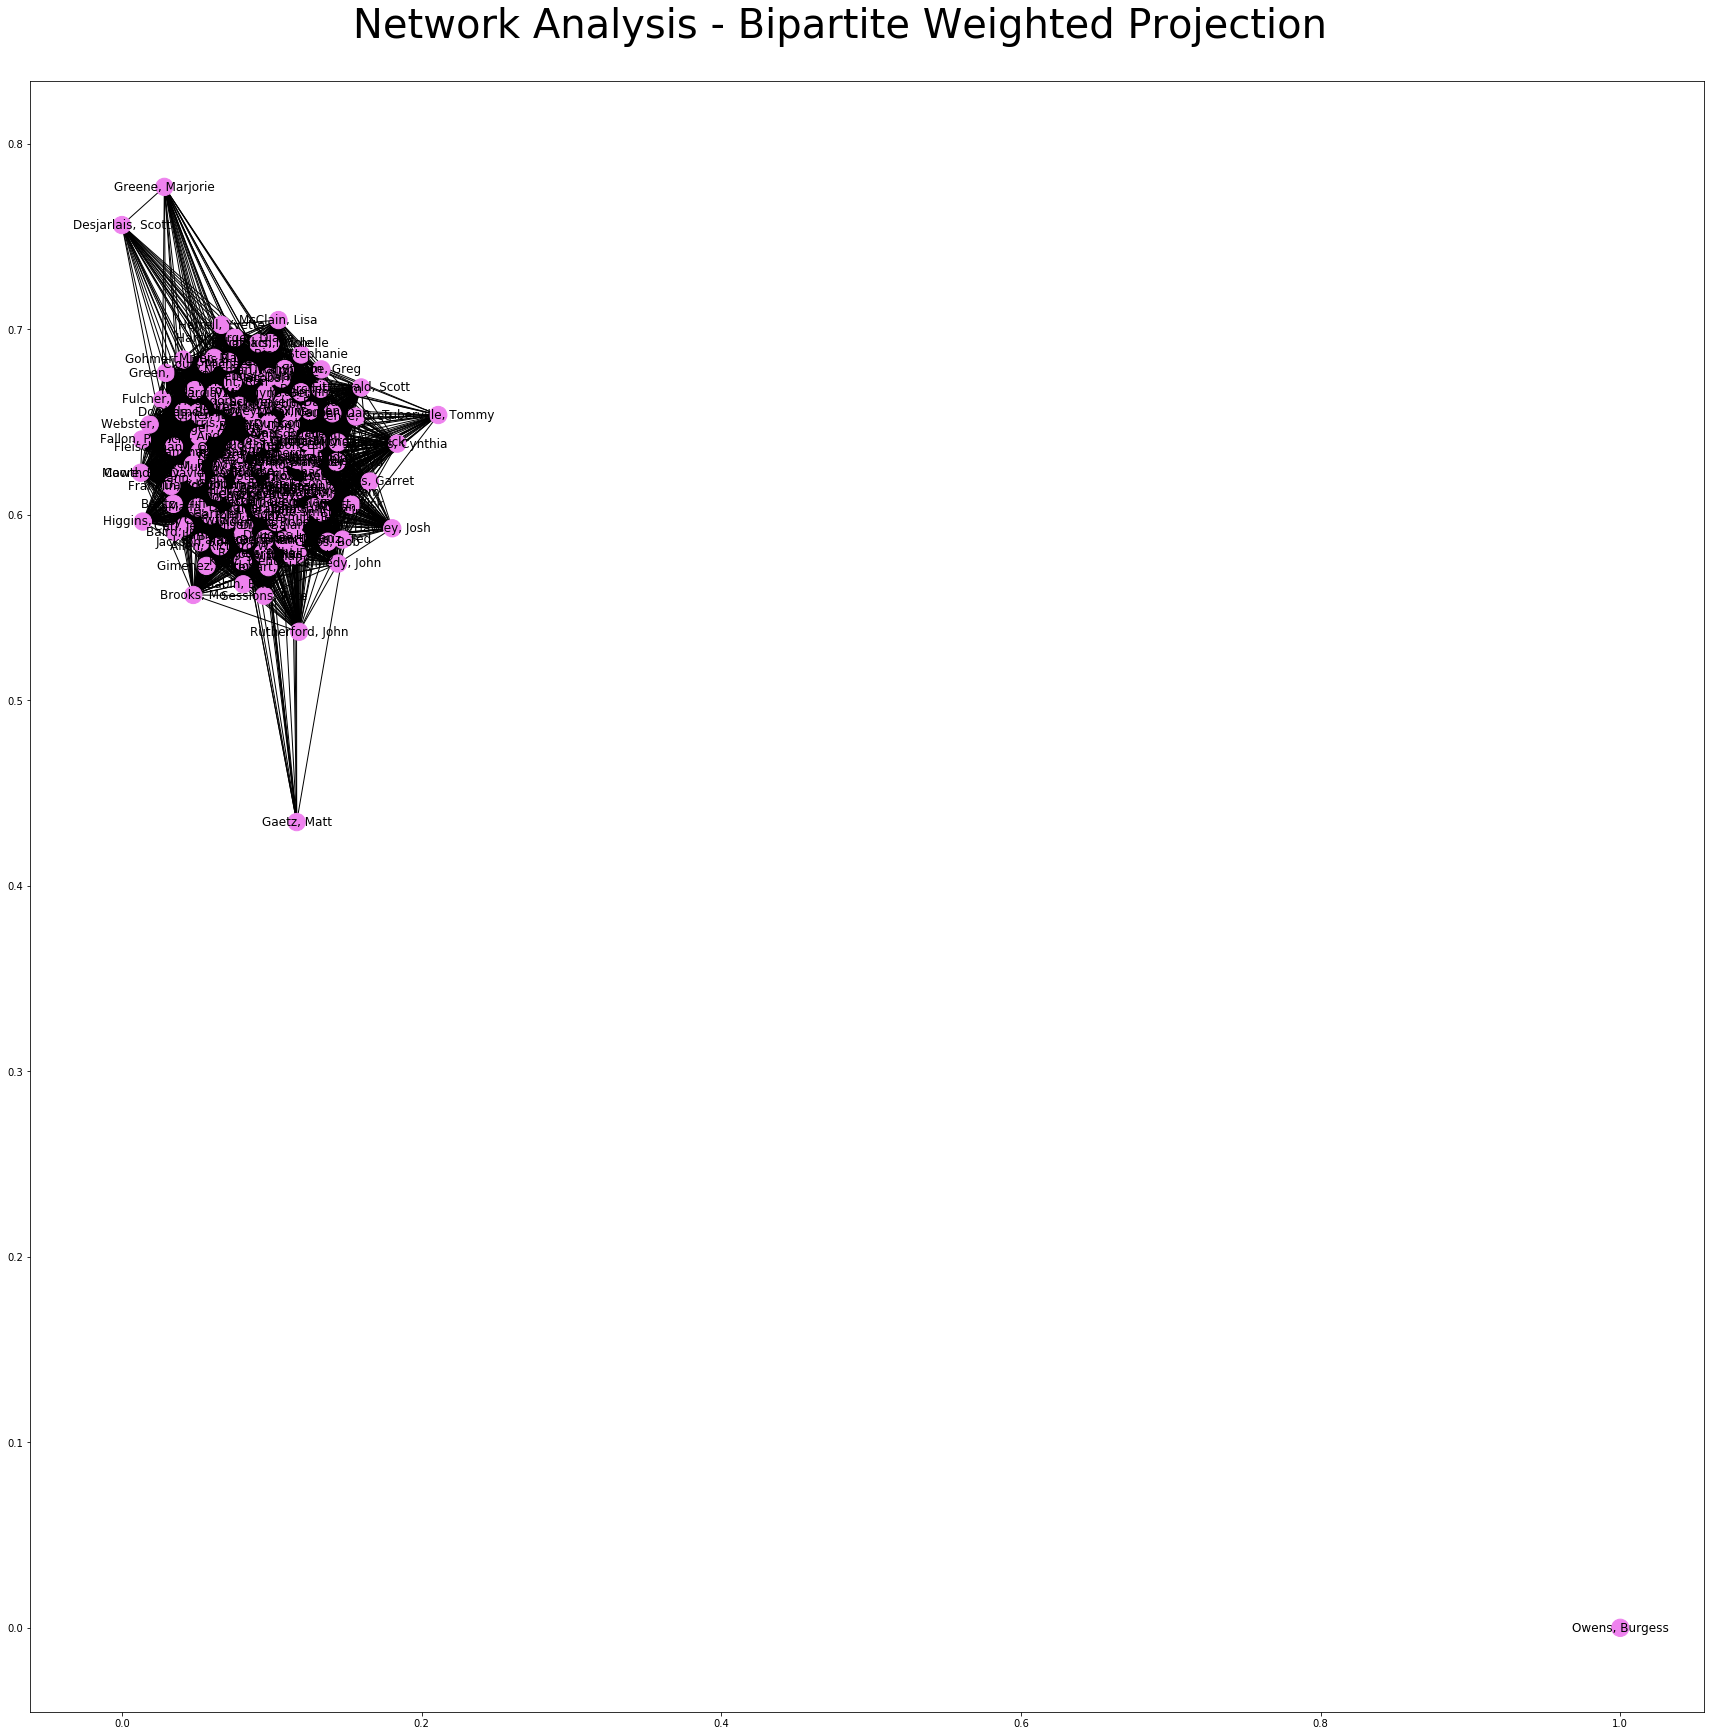

In [162]:
colors = ['lightgreen' if n in pacs else 'violet' for n in lpart]
plt.figure(figsize = (30, 30))
ax = plt.subplot()

nx.draw_networkx(lpart, ax=ax, node_color=colors, seed=620)

plt.figtext(.5,.9,'Network Analysis - Bipartite Weighted Projection', fontsize=40, ha='center')
plt.show()

In [152]:
bipartite.weighted_projected_graph?

In [157]:
nx.layout?

In [160]:
#nx.write_graphml(lpart, "lpart_test.graphml")

----------(below is the original notebook)-------------

In [35]:
#nx.write_graphml(subgraph_test, "subgraph_test.graphml")

In [150]:
from IPython.display import IFrame

In [151]:
IFrame('https://ebhtra.github.io/gory-graph/network/', width=1000, height=1000)